# Set Up
Considering that the overall process may take a long time and Colab execution may be interrupted, we highly recommend mounting your Google Drive to Colab to save intermediate results.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set Up Parameters

Please make sure to update the following parameters to your own:

- **Project ID**: The BigQuery project ID to query the MIMIC III v1.4 raw data. (If you're not sure what your project ID is, check details in `notebooks/MIMIC_III_data_access_instructions.ipynb`.)
- **BASE_PATH**: The path where the GitHub project will be cloned.



In [2]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/PTSM_Private_Testing"

## Clone GitHub Repo

In [3]:
# Change to the specified path and clone the repository
%cd {BASE_PATH}
!git clone git@github.com:bettyJin/Post_Traumatic_Sepsis_MIMICIII.git
%cd {BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII/
!ls

/content/drive/MyDrive/PTSM_Private_Testing
fatal: destination path 'Post_Traumatic_Sepsis_MIMICIII' already exists and is not an empty directory.
/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII
data	 LICENSE     notebooks	README.md	  scripts   src
dataset  MaybeLater  OldDraft	requirements.txt  setup.py  supplementary


## Initialize

In [5]:
# Initialize the ProjectPaths object
!ls
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII')

data	 LICENSE     notebooks	README.md	  scripts   src
dataset  MaybeLater  OldDraft	requirements.txt  setup.py  supplementary


# Test MIMIC Dataset Access

Test if Google Colab can successfully access the MIMIC III v1.4 data through BigQuery.

**If you are not sure or would like to apply for access**, please refer to the `notebooks/MIMIC-III_Data_Access_Instructions.ipynb`.



In [6]:
from src.data import data_utils
print("This is your PROJECT_ID: ",PROJECT_ID)
data_utils.test_mimiciii_bigquery_access(PROJECT_ID)

This is your PROJECT_ID:  sepsis-mimic3
Successfully accessed the MIMIC III Via BigQuery


True

<!-- If the above block of code **runs into any error**, here is your checklist:

1. Test your access on the Google BigQuery console (details in the section of "Test Access on Google BigQuery").
2. When prompted to log in, make sure you use **the Google account** granted access to MIMIC-III via PhysioNet (the account used for the BigQuery console).
3. Check if you have set up the correct **Project ID**. If you're not sure what your project ID is, refer to section Section1 and Section 2 in notebooks/MIMIC-III_data_access_instructions.ipynb. -->


**If the above block of code runs into any errors, here is your checklist:**

1. Test your access on the Google BigQuery console (see Section 1 in `notebooks/MIMIC-III_data_access_instructions.ipynb` for details).
2. When prompted to log in, ensure you use **the Google account** that has been granted access to MIMIC-III via PhysioNet (the same account used for the BigQuery console).
3. Verify that you have set up the correct **Project ID**. If you are unsure of your project ID, refer to Section 1 in `notebooks/MIMIC-III_data_access_instructions.ipynb`.


# Cohort Extraction: Critically Ill Trauma Patients

This section extracts a cohort of critically ill trauma patients from the MIMIC-III v1.4 dataset, applying stringent criteria including age range, admission duration, and mechanical ventilation days, as detailed in Section 3.1, "Cohort Extraction: Critically Ill Trauma Patients," of our paper "Rare Event Early Detection: Sepsis Onset for Critically Ill Trauma Patients."

### Cohort Criteria:

- **Instance ID**: Use qualified `HADM_ID` as the instance ID.
- **ICD-9 E-codes Selection**: Select trauma patients according to ICD-9 E-codes.
- **Age Criteria**: Include patients aged 18-89 years.
- **Hospital Stay Duration**: Include admissions with a hospital stay duration of at least 48 hours.
- **Ventilation Days**: Include patients with at least 3 days of mechanical ventilation.

The refined cohort, tailored for studying early sepsis onset detection, comprises **1,570 admissions**. Detailed explanations of the cohort extraction process and other relevant details can be found in `'notebooks/Cohort_Extraction.ipynb'`.

**Note:** The first time running the following block may take about 7 minutes.





In [7]:
from scripts.cohort_extraction import extract_trauma_cohort_ids
# Extract cohort IDs and generate a statistics report
trum_ids = extract_trauma_cohort_ids(project_path_obj,    # Saved File Paths
                      PROJECT_ID,          # To query raw data
                      is_report=True,      # Print statistics report
                      is_saved=True        # Save the cohort IDs
)

,TOTAL,TRUM basic filter,TRUM Vent filter
subject_id,46428,4826,1551
hadm_id,57328,4977,1570
icustay_id,61051,5410,1828


MIMIC III includes: 57328 (qualified hospital admissions)
After Trauma Selection (ICD-9): 6148
After Age Filter: 5651
After Hospital Length of Stay >= 48h Filter: 4977
	Hospital Length of Stay < 48h: 674 = 200 (Died) + 474 (Discharged Alive)
Mechanical Ventilation Day Filter: 
	2271 (Not Intubated) + 1136 (Intubated < 3 days)
Final Cohort Size: 1570
Save to:  /content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/data/processed/trauma_cohort_info.csv


# Assign Post-Trauma Sepsis Onset Label

This section calls the core function for sepsis label assignment, which integrates essential criteria to accurately assign sepsis labels and timestamp sepsis onset in the critically ill trauma cohort from the MIMIC-III v1.4 dataset, as detailed in Section 3.2, "Post-trauma Sepsis Definition," of our paper. Detailed explanations and applications can be found in `notebooks/Sepsis_Onset_Label_Assignment.ipynb`.

### Step 1: Preprocess Pertinent Features
We preprocess data from four primary tables to establish the sepsis definition for the trauma cohort within the MIMIC-III dataset:
- **Cohort Admit Info**: Contains trauma cohort patient IDs and corresponding admission information.
- **Blood Culture**: Includes blood culture events taken at or after 72 hospital hours.
- **Antibiotics**: Includes qualifying antibiotic events, selected and cleaned based on:
      - **Route**: Must be administered intravenously (IV) or orally for specific antibiotics (e.g., vancomycin, linezolid).
      - **NewAbx**: The antibiotic must not have been administered on the previous day.
      - **FirstDay**: Must not have been administered on the first hospital day.
      - **Prophylaxis**: Excludes antibiotics used exclusively for surgical prophylaxis.
      - **Duration**: Must be administered for at least four consecutive days or until death/discharge.
- **Modified SOFA Score**: Includes the Sequential Organ Failure Assessment (SOFA) score for every hour of the trauma cohort's ICU stay, with the Glasgow Coma Scale (GCS) and Urine Output (UO) components excluded from the standard SOFA score.

### Step 2: Define Post-Trauma Sepsis
Post-Trauma Sepsis is defined based on preprocessed data following Sepsis-3 consensus guidelines. It is identified as a clinically suspected infection associated with acute worsening of organ dysfunction. The sepsis onset time is defined as the chart time of the first sepsis onset candidate.

**Criteria for Sepsis Onset Candidate Timestamp**:
- **Qualifying Culture Timestamp**: Must be for a qualifying blood culture's chart time.
- **Suspected Infection**: Identified by blood culture records (specifically chart time) within a 5-day window of qualifying antibiotic initiation.
- **Organ Dysfunction**: Identified by a **2-point increase** in the SOFA score within a 7-day window (-3 days, day of, +3 days) relative to the culture chart time.

### Step 3: Post-Process Sepsis Candidates
Finally, we assign sepsis labels and onset timestamps as follows:
- **Non-Sepsis**: If a patient (HADM_ID) has no qualified sepsis candidates, they are labeled as non-sepsis, with the onset time set to NaN.
- **Sepsis**: If a patient (HADM_ID) has more than one sepsis candidate, we retain only the earliest culture timestamp as the onset time.

### Summary
Among the 1,570 trauma admissions analyzed, 729 admissions had suspected infections, and 535 had confirmed sepsis. As shown in the following section's graph, the peak of sepsis onset occurs on the 5th day after hospital admission.

**Note**: The first time running the following block may take about **23 minutes**.



╔══════════════════════════════════╗
║        Preprocessing Data        ║
╚══════════════════════════════════╝
--------------Trauma Cohort Information--------------
Loading trauma cohort information...
Loaded 1570 trauma patients.

--------------Blood Culture Events-------------------
Loading blood culture events...
Loaded 8821 records for 1037 unique patients.
After processing (drop duplicates), 3826 unique records remain.

--------------Antibiotic Events----------------------
Loading antibiotic events...
Loaded 2780 records for 1006 unique patients.
After processing (drop duplicates), 2039 unique records remain.

--------------SOFA Scores----------------------------
Loading SOFA scores...
Loaded 433825 records for 1570 unique patients.
After processing, 433825 unique records remain.


╔══════════════════════════════════╗
║      Assigning Sepsis Labels     ║
╚══════════════════════════════════╝
Number of trauma patients: 1570
Number of infections: 729.0
Number of sepsis cases: 535.0


,onset_day
count,535.000000
mean,7.274766
std,4.603087
min,4.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,51.000000


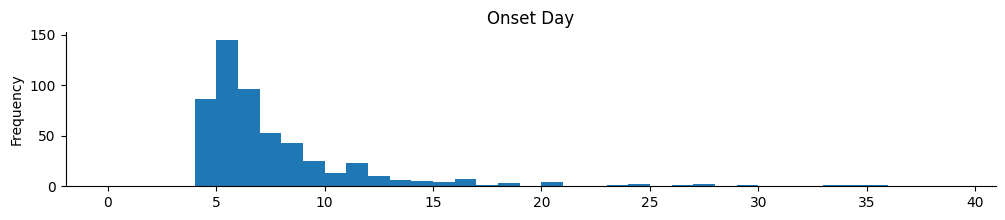

Saving sepsis label information at /content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/data/processed/sepsis_label.csv


In [8]:
from scripts.sepsis_onset_label_assignment import assign_sepsis_labels
# Assign sepsis labels and onset times for each patient in the cohort
sepsis_label_df = assign_sepsis_labels(project_path_obj,  # Saved File Paths
                                       PROJECT_ID         # To query raw data
                                       )

# Generate Dataset
In this section, we will load the complete Post-Traumatic Sepsis dataset (without missing values), which is derived from the MIMIC-III v1.4 dataset. For a comprehensive explanation of the dataset construction and additional relevant information, please refer to the `notebooks/Early_Sepsis_Onset_Detection_Setup.ipynb` file.

The dataset table comprises the following columns:

- **Temporal Features**: Multivariate time-series input data with dimensions (# of timestamps, # of features).
- **Label**: Binary value (0 or 1) representing the output label.
- **Dataset**: Indicates whether the instance is part of the training or test set.

Each row in the dataset corresponds to one nighttime instance, and includes patient identifiers (`subject_id`, `hadm_id`) and a timestamp ID (`Date`, `Night`).

In [9]:
from scripts.early_sepsis_onset_detection_setup import dataset_construction

data_with_nan_df, data_wo_nan_df = dataset_construction(project_path_obj, PROJECT_ID, is_report=True)

Generating Dataset without NaN values...
Extracted 176832 FiO2 samples for 1570 trauma patients.
Extracted 686235 vital sign samples for 1570 trauma patients.
Total samples after merging 2 tables: 702641 for 1570 trauma patients.
Extracted nighttime data with filling window: 702641 samples for 1570 trauma patients
After filling in missing timestamps: 727066 samples for 1570 trauma patients
After forward and backward filling: 727066 samples for 1570 trauma patients
After aggregating one hour into one value: 440972 samples for 1570 trauma patients
After dropping NaN values: 382343 samples for 1569 trauma patients
After removing filling window: 153639 samples for 1569 trauma patients
After retaining complete nights: 153639 samples for 1569 trauma patients
After aggregating one night into 2D time-series, 17071 samples for 1569 trauma patients.
After filtering out the first night, 15698 samples for 1568 trauma patients.
After filtering out nights beyond day 14, 11308 samples for 1550 trauma

,NumInstance,NumPosInstance,RatioPosInstance,NumPatient(subject_id),NumSepPatient(subject_id),RatioSepPatient(subject_id)
test,1249,58,0.046,162,58,0.358
train,9316,393,0.042,1357,392,0.289


For data table w/o NaN with shape (9920, 7) for 1523 patients(hadm_id).


,NumInstance,NumPosInstance,RatioPosInstance,NumPatient(subject_id),NumSepPatient(subject_id),RatioSepPatient(subject_id)
test,1250,57,0.046,162,57,0.352
train,8670,367,0.042,1344,366,0.272


# Machine Learning Training Pipeline Documentation

### 1. **Simple Solutions for Datasets Without Missing Values**

This pipeline focuses on the Post-Traumatic Sepsis dataset **without missing values**, targeting Rare Event Early Detection, specifically Sepsis Onset.

**Key Techniques:**
- **Reweighting:** Adjusting class weights.
- **Resampling:** Balancing the dataset by over-sampling or under-sampling.
- **Augmentation:** Generating synthetic samples.

The pipeline evaluates the effectiveness and limitations of these methods in handling the class imbalance, where positive instances represent about 4% of the dataset. Detailed explanations and applications can be found in `notebooks/ML_Pipeline_No_Missing.ipynb`.

#### Performance Comparison of Different Methods (Average of 5-Fold Cross-Validation)
| Method                    | Precision | Recall   | F1_score | AUC (PR) | Specificity | TN    | FP    | FN    | TP    |
|---------------------------|-----------|----------|----------|----------|-------------|-------|-------|-------|-------|
| Simple Classification      | 0.0       | 0.0      | 0.0      | 0.569237 | 1.0         | 1660.6| 0.0   | 73.4  | 0.0   |
| Reweighting                | 0.048253  | 0.458521 | 0.086815 | 0.556912 | 0.596183    | 986.2 | 674.4 | 39.8  | 33.6  |
| Augmentation: TimeWarp     | 0.0       | 0.0      | 0.0      | 0.555446 | 1.0         | 1660.6| 0.0   | 73.4  | 0.0   |
| Undersampling + Oversampling | 0.050142 | 0.441644 | 0.089228 | 0.541260 | 0.618681    | 1020.8| 639.8 | 41.0  | 32.4  |
| SMOST                      | 0.041939  | 0.346630 | 0.074615 | 0.516961 | 0.649277    | 1076.0| 584.6 | 48.0  | 25.4  |
| SMOTE + TimeWarp           | 0.044556  | 0.444968 | 0.080578 | 0.522805 | 0.577693    | 953.2 | 707.4 | 40.8  | 32.6  |

### 2. **Masked Autoencoder for Datasets with Missing Values**

This pipeline addresses the challenges of **missing data** and class imbalance in the Post-Traumatic Sepsis dataset.

**Approach:**
- **Masked Autoencoder (MAE):** Pre-trains on missing data, learning robust feature representations and serving as data augmentation.
- **Classifier:** Applied after MAE pre-training for sepsis onset detection.

The pipeline effectively manages missing values and the significant class imbalance, where positive samples constitute approximately 4% of the data. Detailed explanations and applications can be found in `notebooks/ML_Pipeline_with_Missing.ipynb`.

#### Cross-Validation Metrics Summary

| Fold | Num Train Samples | Num Train Patients | Num Val Samples | Num Val Patients | Precision | Recall  | F1 Score | AUC (PR) | Specificity | TN  | FP  | FN  | TP  | Reconstruct Error |
|------|-------------------|--------------------|-----------------|------------------|-----------|---------|----------|-----------|-------------|------|------|------|------|------------------|
| 1    | 14,158             | 1,085              | 1,923           | 272              | 0.047252  | 0.620253 | 0.087814 | 0.561499  | 0.464208    | 856  | 988  | 30   | 49   | 6.369861          |
| 2    | 14,178             | 1,085              | 1,913           | 272              | 0.043912  | 0.556962 | 0.081406 | 0.516813  | 0.477644    | 876  | 958  | 35   | 44   | 6.655287          |
| 3    | 14,206             | 1,086              | 1,898           | 271              | 0.043197  | 0.512821 | 0.079681 | 0.538955  | 0.513187    | 934  | 886  | 38   | 40   | 6.600450          |
| 4    | 14,446             | 1,086              | 1,779           | 271              | 0.047091  | 0.645570 | 0.087780 | 0.556750  | 0.392941    | 668  | 1,032 | 28   | 51   | 6.436116          |
| 5    | 14,396             | 1,086              | 1,803           | 271              | 0.047410  | 0.692308 | 0.088743 | 0.580654  | 0.371014    | 640  | 1,085 | 24   | 54   | 6.519011          |
| **Average** | **14,276.8**     | **1,085.6**          | **1,863.2**         | **271.4**        | **0.045772** | **0.605583** | **0.085085** | **0.550934** | **0.443799**  | **794.8** | **989.8** | **31.0** | **47.6** | **6.516145**        |

